# Step 1: Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error ,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from statsmodels.tsa.seasonal import seasonal_decompose

import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam, Nadam, SGD

# Step 2: Reading Dataset

In [2]:
df = pd.read_csv('/content/Gold Price (2013-2023).csv')

# Step 3: Dataset Overview

In [3]:
df

,Date,Close,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%
...,...,...,...,...,...,...,...
2578,1/8/2013,"1,663.20","1,651.50","1,662.60","1,648.80",0.13K,0.97%
2579,1/7/2013,"1,647.20","1,657.30","1,663.80","1,645.30",0.09K,-0.16%
2580,1/4/2013,"1,649.90","1,664.40","1,664.40","1,630.00",0.31K,-1.53%
2581,1/3/2013,"1,675.60","1,688.00","1,689.30","1,664.30",0.19K,-0.85%


__Như chúng ta có thể thấy, bộ dữ liệu bao gồm thông tin giá vàng hàng ngày bao gồm giá Mở cửa, Cao và Thấp hàng ngày và giá cuối cùng của mỗi ngày (Close) cùng với khối lượng giao dịch và sự thay đổi giá trong mỗi ngày.__

In [4]:
df.describe()

,Date,Close,Open,High,Low,Vol.,Change %
count,2583,2583,2583,2583,2583,2578,2583
unique,2583,2072,2061,2044,2019,1550,474
top,12/30/2022,"1,294.30","1,284.00","1,220.00","1,314.00",0.02K,0.00%
freq,1,5,5,6,5,48,29


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2583 non-null   object
 1   Close     2583 non-null   object
 2   Open      2583 non-null   object
 3   High      2583 non-null   object
 4   Low       2583 non-null   object
 5   Vol.      2578 non-null   object
 6   Change %  2583 non-null   object
dtypes: object(7)
memory usage: 141.4+ KB


# Step 4: Data Preparation

## Step 4.1: Feature Subset Selection
__Vì chúng tôi sẽ không sử dụng "Vol." và "Change %"  để dự đoán Giá, chúng tôi sẽ bỏ hai thuộc tính này:__

In [6]:
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

## Step 4.2: Transforming Data

__"Date" được chuyển đổi kiểu dữ liệu của nó thành datetime và sau đó sắp xếp tính năng này theo thứ tự tăng dần:__

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df.sort_index(inplace=True)

In [8]:
df

,Date,Close,Open,High,Low
0,2013-01-02,"1,689.90","1,675.80","1,695.00","1,672.10"
1,2013-01-03,"1,675.60","1,688.00","1,689.30","1,664.30"
2,2013-01-04,"1,649.90","1,664.40","1,664.40","1,630.00"
3,2013-01-07,"1,647.20","1,657.30","1,663.80","1,645.30"
4,2013-01-08,"1,663.20","1,651.50","1,662.60","1,648.80"
...,...,...,...,...,...
2578,2022-12-26,"1,809.70","1,805.80","1,811.95","1,805.55"
2579,2022-12-27,"1,823.10","1,808.20","1,841.90","1,808.00"
2580,2022-12-28,"1,815.80","1,822.40","1,822.80","1,804.20"
2581,2022-12-29,"1,826.00","1,812.30","1,827.30","1,811.20"


__Dấu " , " là dư thừa trong tập dữ liệu. Đầu tiên, chúng tôi xóa nó khỏi toàn bộ tập dữ liệu và sau đó thay đổi kiểu dữ liệu của các biến số thành float:__

In [9]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

__Do dữ liệu theo ngày bị thiếu nên chúng tôi sự dụng phương pháp interpolation(nội suy) để thay thế các phần tử NaN:__

In [10]:
all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max())
df_full = df.set_index('Date').reindex(all_dates)

df_full['Close'] = df_full['Close'].interpolate(method='linear')
df_full['Open'] = df_full['Open'].interpolate(method='linear')
df_full['High'] = df_full['High'].interpolate(method='linear')
df_full['Low'] = df_full['Low'].interpolate(method='linear')

In [11]:
df = df_full.copy()
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)

In [12]:
df

,Date,Close,Open,High,Low
0,2013-01-02,1689.9,1675.800000,1695.00,1672.10
1,2013-01-03,1675.6,1688.000000,1689.30,1664.30
2,2013-01-04,1649.9,1664.400000,1664.40,1630.00
3,2013-01-05,1649.0,1662.033333,1664.20,1635.10
4,2013-01-06,1648.1,1659.666667,1664.00,1640.20
...,...,...,...,...,...
3645,2022-12-26,1809.7,1805.800000,1811.95,1805.55
3646,2022-12-27,1823.1,1808.200000,1841.90,1808.00
3647,2022-12-28,1815.8,1822.400000,1822.80,1804.20
3648,2022-12-29,1826.0,1812.300000,1827.30,1811.20


In [13]:
df.describe()

,Date,Close,Open,High,Low
count,3650,3650.000000,3650.000000,3650.000000,3650.000000
mean,2017-12-31 12:00:00,1439.724034,1440.154890,1449.072623,1430.325390
min,2013-01-02 00:00:00,1049.600000,1051.500000,1060.100000,1045.400000
25%,2015-07-03 06:00:00,1243.800000,1243.900000,1251.000000,1235.575000
50%,2017-12-31 12:00:00,1320.450000,1320.600000,1326.500000,1313.500000
75%,2020-06-30 18:00:00,1712.700000,1711.050000,1722.458333,1698.625000
max,2022-12-30 00:00:00,2058.400000,2065.100000,2078.700000,2037.200000
std,NaN,257.308107,257.650598,259.687180,254.826534


## Step 4.3: Checking Duplicates
__Kiểm tra trùng lặp trong "Date" :__

In [14]:
df.duplicated().sum()

0

## Step 4.4: Checking Missing Values
__Kiểm tra giá trị thiếu:__

In [15]:
df.isnull().sum()

Date     0
Close    0
Open     0
High     0
Low      0
dtype: int64

# Step 5: Visualizing Gold Price History Data

__Biểu đồ giá vàng theo thời gian:__

In [16]:
fig = px.line(y=df.Close, x=df.Date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Date",
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  xaxis=dict(showgrid=True, griddash="dash" ),
                  yaxis=dict(showgrid=True, griddash="dash"))


# Step 6: Splitting Data to Training & Test Sets
__Chúng tôi chia tập dữ liệu thành 2 phần train và test. Tập test là dữ liệu năm 2022 (năm cuối cùng):__

In [17]:
test_size = df[df.Date.dt.year==2022].shape[0]
train_size = df.shape[0] - test_size
test_size

364

__Biểu đồ dữ liệu train và test:__

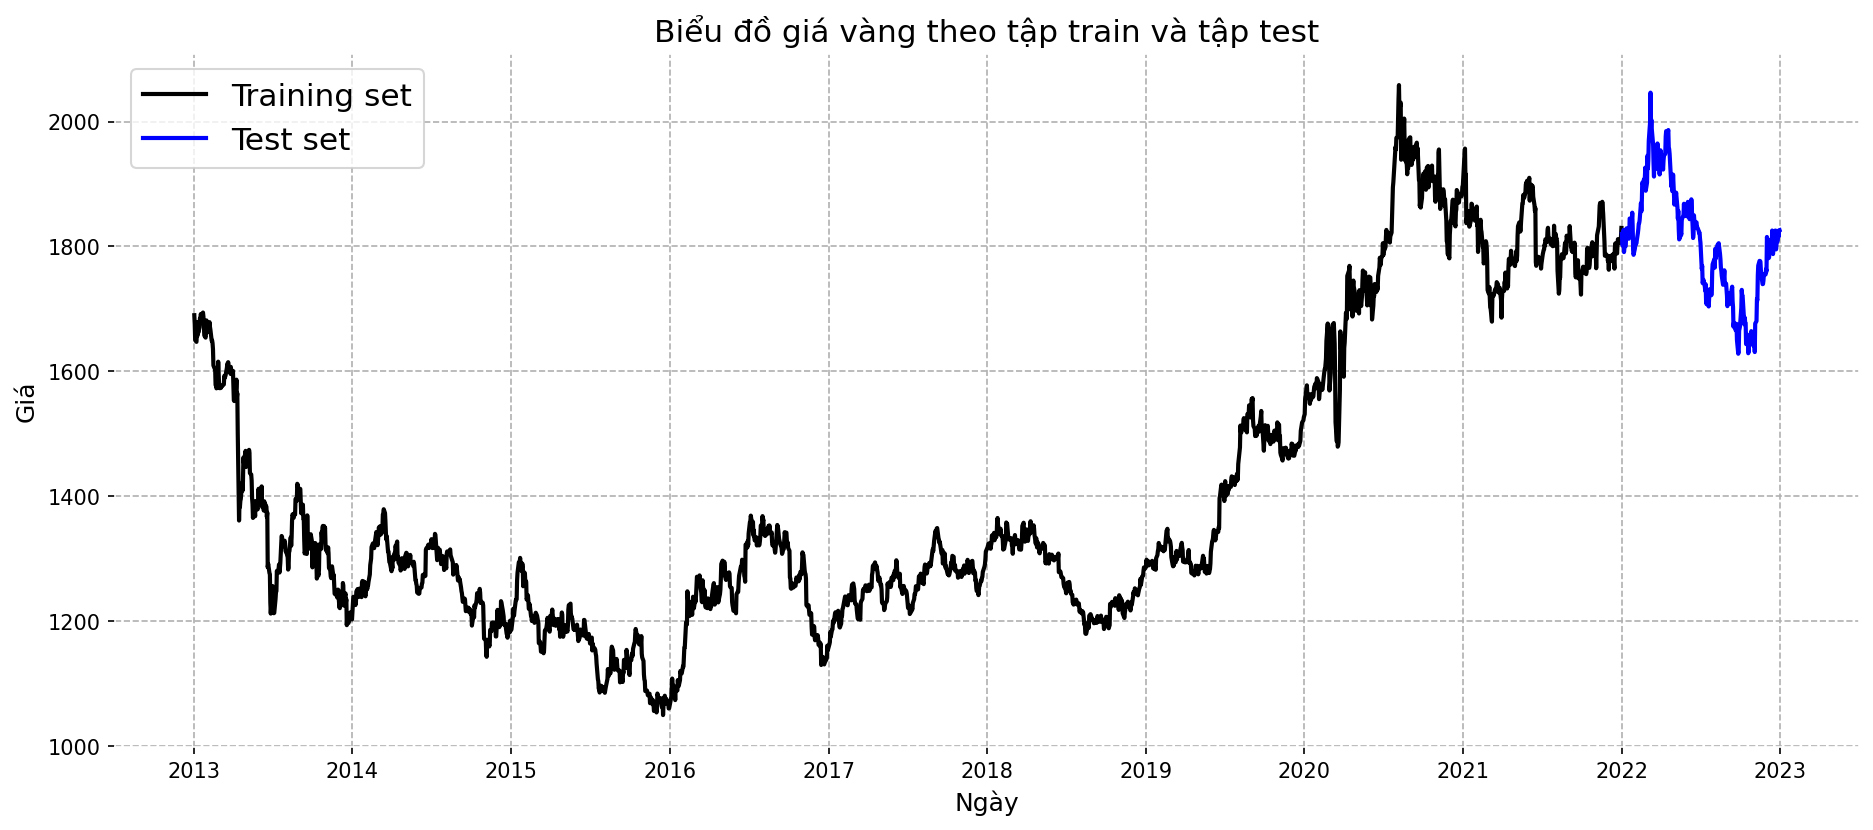

In [18]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Close[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Close[-test_size:], color='blue', lw=2)
plt.title('Biểu đồ giá vàng theo tập train và tập test', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(linestyle= "--")
plt.show()

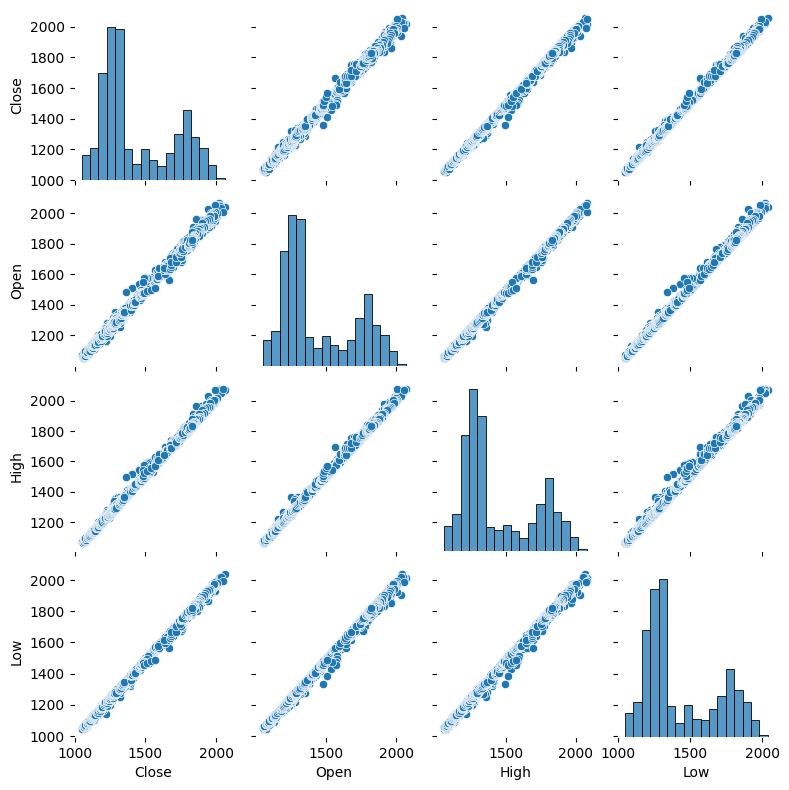

In [19]:
sns.pairplot(data = df, height = 2)

Text(0.5, 1.0, 'Biểu đồ tương quan')

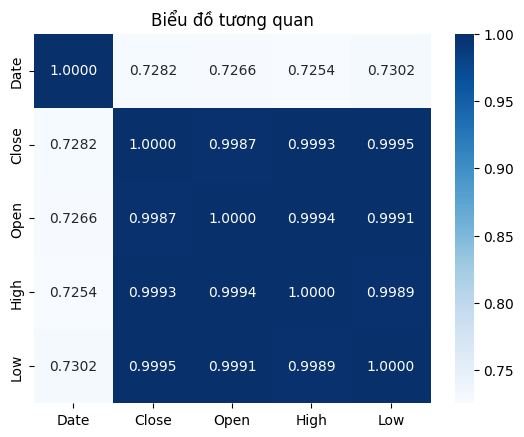

In [20]:
sns.heatmap(df.corr(),cmap='Blues',annot=True,fmt='.4f')
plt.title('Biểu đồ tương quan')

**Các biểu đồ tương quan về các giá trị cho thấy giá vàng ít có sự chênh lệch đột biến nào đó**

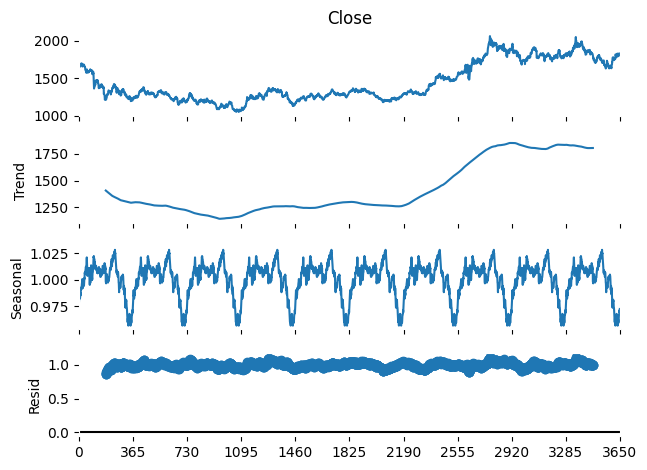

In [21]:
decomposition = seasonal_decompose(df['Close'], model='multiplicative', period=365)
decomposition.plot()
plt.xticks([num for num in range(0, 3700) if num % 365 == 0])
plt.show()

**Nhận xét:**


*   **Trend:** Xu hướng này được chiết xuất từ dữ liệu gốc và cho thấy sự thay đổi dài hạn của dữ liệu. Biểu đồ cho thấy xu hướng giảm nhẹ ban đầu và sau đó tăng lên rõ rệt ở giai đoạn sau.
*   **Seasonal:**  Biểu đồ cho thấy có sự dao động định kỳ rõ rệt, điều này cho thấy dữ liệu có tính mùa vụ mạnh mẽ.
*   **Residual:**  Biểu đồ này hiển thị phần dư, tức là sự khác biệt giữa giá trị thực tế và giá trị dự đoán từ mô hình (bao gồm xu hướng và tính mùa vụ). Phần dư dao động xung quanh giá trị 1 và không có mẫu hình rõ ràng, điều này cho thấy phần dư không có xu hướng hoặc tính mùa vụ còn lại, và mô hình đã loại bỏ được xu hướng và tính mùa vụ khá tốt



# Step 7: Restructure Data & Create Sliding Window
__Áp dụng kỹ thuật Slide window chuyển thành bài toán Supervised learning với window size = 10__

In [22]:
window_size = 10

**Scaling**

In [23]:
# scaler = MinMaxScaler()
scaler = StandardScaler()

__Training Set:__

In [24]:
train_data = df.Close[:-test_size]
train_data = scaler.fit_transform(train_data.values.reshape(-1,1))

In [25]:
X_train = []
y_train = []

for i in range(window_size, train_size):
    X_train.append(train_data[i-10:i, 0])
    y_train.append(train_data[i, 0])

In [26]:
X_train[0]

array([1.22685438, 1.16650083, 1.05803325, 1.05423478, 1.0504363 ,
       1.04663782, 1.11416628, 1.08588874, 1.18085062, 1.10741343])

__Test Set:__

In [27]:
test_data = df.Close[-test_size-10:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [28]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-10:i, 0])
    y_test.append(test_data[i, 0])


# Step 10: Using Linear Regression, Random Forest, SVM model

**Chúng tôi sử dụng các chỉ số để đánh giá:**
*   **Test loss**: Cận dưới = 0
*   **MSE**: Cận dưới = 0
*   **MAPE**: Cận dưới = 0
*   **R2**: Cận trên = 1

**Các chỉ số càng tiến tới đường tiệm cận thì độ chính xác của mô hình càng cao.**

## Linear Regression

In [29]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

result_linear = linear_reg.predict(X_test)

MAPE = mean_absolute_percentage_error(y_test, result_linear)
MAE = mean_absolute_error(y_test, result_linear)
R2 = r2_score(y_test, result_linear)

print("Test Loss:", result_linear[-1])
print("Test MAE:", MAE)
print("Test MAPE:", MAPE)
print("Test R2 Score:", R2)

Test Loss: 1.801843901180386
Test MAE: 0.03987120288642638
Test MAPE: 0.023939833185288386
Test R2 Score: 0.9774660011645203


## Random Forest

In [30]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)

result_rf = rf_reg.predict(X_test)

MAPE = mean_absolute_percentage_error(y_test, result_rf)
MAE = mean_absolute_error(y_test, result_rf)
R2 = r2_score(y_test, result_rf)

print("Test Loss:", result_rf[-1])
print("Test MAE:", MAE)
print("Test MAPE:", MAPE)
print("Test R2 Score:", R2)

Test Loss: 1.7944704065362285
Test MAE: 0.04643163491367564
Test MAPE: 0.028684803170451384
Test R2 Score: 0.9716752140695497


## SVM

In [31]:
svm_reg = SVR()
svm_reg.fit(X_train, y_train)

result_svm = svm_reg.predict(X_test)

MAPE = mean_absolute_percentage_error(y_test, result_svm)
MAE = mean_absolute_error(y_test, result_svm)
R2 = r2_score(y_test, result_svm)

print("Test Loss:", result_svm[-1])
print("Test MAE:", MAE)
print("Test MAPE:", MAPE)
print("Test R2 Score:", R2)

Test Loss: 1.7982303379455717
Test MAE: 0.04399983527509369
Test MAPE: 0.026413935393271883
Test R2 Score: 0.9745419735748861


# Step 9: Converting Data to Numpy Arrays



In [32]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [33]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [34]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (3276, 10, 1)
y_train Shape:  (3276, 1)
X_test Shape:   (364, 10, 1)
y_test Shape:   (364, 1)


# Step 10: LSTM Network


__Model Definition:__

In [35]:
def define_model(units1, units2, optimizer):
    input1 = Input(shape=(window_size, 1))
    x = LSTM(units=units1, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = LSTM(units=units2)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[output])
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.summary()

    return model


__Model Training:__

In [36]:
adam_optimizer = Adam(learning_rate=0.001)
sgd_optimizer = SGD(learning_rate=0.001)
nadam_optimizer = Nadam(learning_rate=0.001)

units1_list = [8, 16, 32, 64]
units2_list = [8, 16, 32, 64]
batch_sizes = [16, 32, 64, 128]
optimizers = [adam_optimizer, sgd_optimizer, nadam_optimizer]

results = []

best_model = None
best_loss = np.inf

for units1 in units1_list:
    for units2 in units2_list:
        for batch_size in batch_sizes:
            for optimizer in optimizers:
                optimizer_name = optimizer.__class__.__name__
                print(f"Training with units1={units1}, units2={units2}, batch_size={batch_size}, optimizer={optimizer_name}")
                model = define_model(units1, units2, optimizer)
                early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

                history = model.fit(X_train, y_train, epochs=300, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[early_stopping])
                val_loss = min(history.history['val_loss'])

                results.append({
                    'units1': units1,
                    'units2': units2,
                    'batch_size': batch_size,
                    'optimizer': optimizer_name,
                    'val_loss': val_loss,
                    'history': history.history['val_loss']
                })

                if val_loss < best_loss:
                    best_loss = val_loss
                    best_model = model
                    print(f"New best model found with val_loss={best_loss}")
                    print("")

print("Best model training complete.")

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Total params: 31297 (122.25 KB)
Trainable params: 31297 (122.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
24/24 [==============================] - 5s 74ms/step - loss: 0.4846 - val_loss: 1.4863
Epoch 2/300
24/24 [==============================] - 1s 46ms/step - loss: 0.2924 - val_loss: 1.0435
Epoch 3/300
24/24 [==============================] - 1s 50ms/step - loss: 0.2464 - val_loss: 0.7849
Epoch 4/300
24/24 [==============================] - 1s 47ms/step - loss: 0.2250 - val_loss: 0.6260
Epoch 5/300
24/24 [==============================] - 1s 58ms/step - loss: 0.2143 - val_loss: 0.5131
Epoch 6/300
24/24 [==============================] - 1s 48ms/step - loss: 0.2076 - val_loss: 0.4470
Epoch 7/300
24/24 [==============================] - 1s 45ms/step - loss: 0.2052 - val_loss: 0.3979
Epoch 8/300
24/24 [==============================] - 1s 45ms/step - loss:

In [53]:
import json

with open('predictions.json', 'w') as file:
    json.dump(results, file)


In [49]:
results[0]

{'units1': 8,
 'units2': 8,
 'batch_size': 16,
 'optimizer': 'Adam',
 'val_loss': 0.007399852853268385,
 'history': [2.1484625339508057,
  1.1632663011550903,
  0.5881295800209045,
  0.2823714315891266,
  0.12599200010299683,
  0.055350326001644135,
  0.03147140517830849,
  0.022899853065609932,
  0.028447404503822327,
  0.03607690706849098,
  0.036660123616456985,
  0.035677261650562286,
  0.014729642309248447,
  0.0344887338578701,
  0.052732665091753006,
  0.01995822601020336,
  0.021765368059277534,
  0.017919637262821198,
  0.019664840772747993,
  0.021381951868534088,
  0.02542341873049736,
  0.014198570512235165,
  0.010983014479279518,
  0.020308565348386765,
  0.013454693369567394,
  0.032873619347810745,
  0.009986812248826027,
  0.01397782377898693,
  0.024784835055470467,
  0.014624349772930145,
  0.04029042646288872,
  0.02242707461118698,
  0.013240514323115349,
  0.009179388172924519,
  0.007668486330658197,
  0.014993712306022644,
  0.008470037020742893,
  0.00739985285

In [55]:
print("Best Model Information:")
print(f"Units1: {best_model.get_layer(index=1).units}")
print(f"Units2: {best_model.get_layer(index=3).units}")
print(f"Optimizer: {best_model.optimizer.__class__.__name__}")
print(f"Best Validation Loss: {best_loss}")

best_model.summary()

Best Model Information:
Units1: 16
Units2: 32
Optimizer: Nadam
Best Validation Loss: 0.0029039105866104364
Model: "model_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_75 (InputLayer)       [(None, 10, 1)]           0         
                                                                 
 lstm_148 (LSTM)             (None, 10, 16)            1152      
                                                                 
 dropout_148 (Dropout)       (None, 10, 16)            0         
                                                                 
 lstm_149 (LSTM)             (None, 32)                6272      
                                                                 
 dropout_149 (Dropout)       (None, 32)                0         
                                                                 
 dense_148 (Dense)           (None, 32)                1056      
                 

In [52]:
best_model.save('best_model.keras')

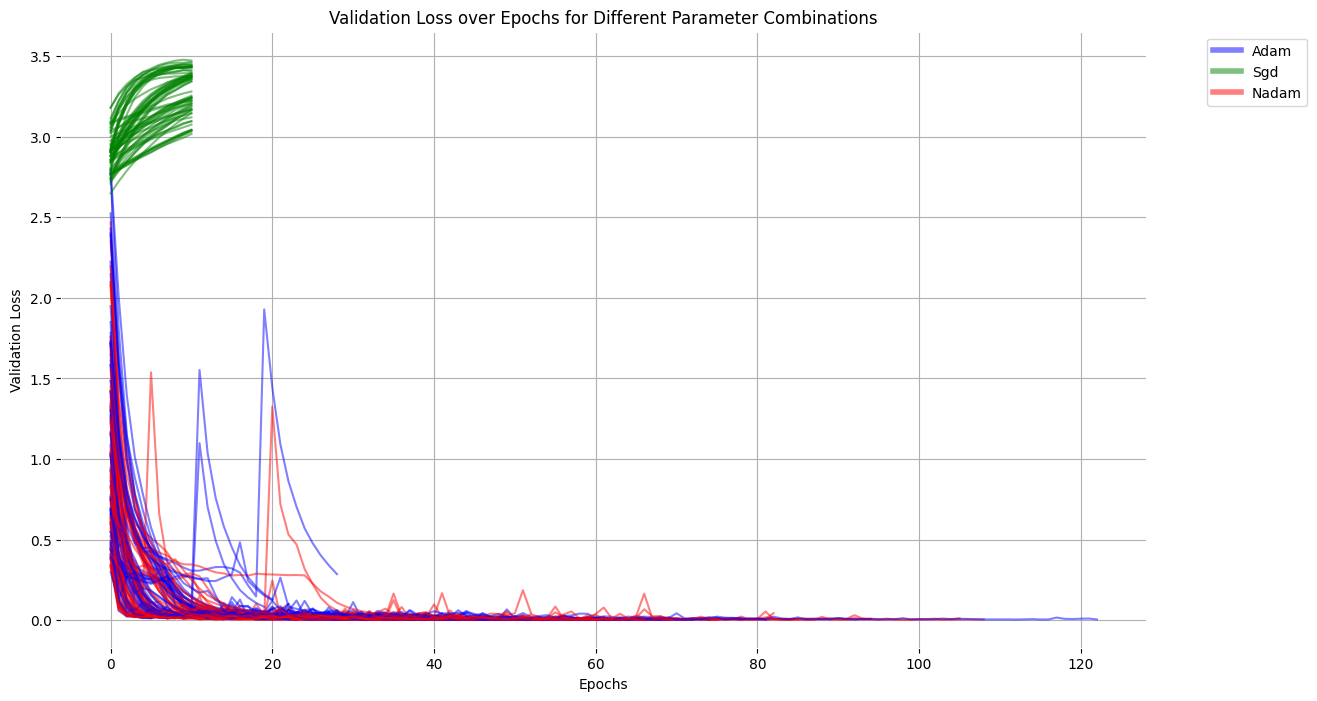

In [58]:
optimizer_colors = {
    'Adam': 'blue',
    'SGD': 'green',
    'Nadam': 'red'
}

unique_optimizers = set(result['optimizer'] for result in results)

plt.figure(figsize=(14, 8))

for result in results:
    label = f"units1={result['units1']}, units2={result['units2']}, batch_size={result['batch_size']}, optimizer={result['optimizer']}"
    color = optimizer_colors.get(result['optimizer'], 'black')  # default to black if optimizer not in dict
    plt.plot(result['history'], label=label, color=color, alpha=0.5)

handles = [plt.Line2D([0], [0], color=optimizer_colors[opt], lw=4, alpha=0.5) for opt in unique_optimizers]
labels = [opt.capitalize() for opt in unique_optimizers]

plt.title('Validation Loss over Epochs for Different Parameter Combinations')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

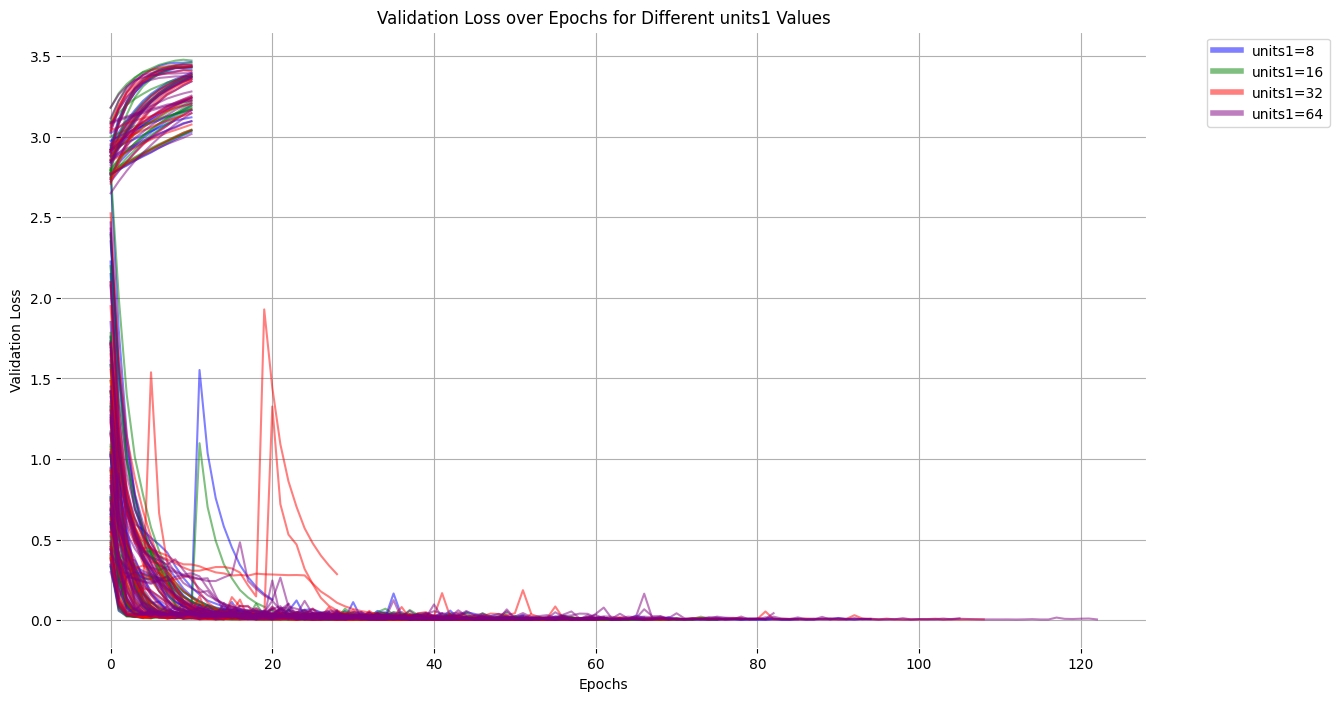

In [59]:
units1_colors = {
    8: 'blue',
    16: 'green',
    32: 'red',
    64: 'purple'
}

# Collect unique units1 values
unique_units1 = set(result['units1'] for result in results)

plt.figure(figsize=(14, 8))

for result in results:
    label = f"units1={result['units1']}, units2={result['units2']}, batch_size={result['batch_size']}, optimizer={result['optimizer']}"
    color = units1_colors.get(result['units1'], 'black')  # default to black if units1 not in dict
    plt.plot(result['history'], label=label, color=color, alpha=0.5)

# Create custom legend for units1
handles = [plt.Line2D([0], [0], color=units1_colors[unit], lw=4, alpha=0.5) for unit in unique_units1]
labels = [f"units1={unit}" for unit in unique_units1]

plt.title('Validation Loss over Epochs for Different units1 Values')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


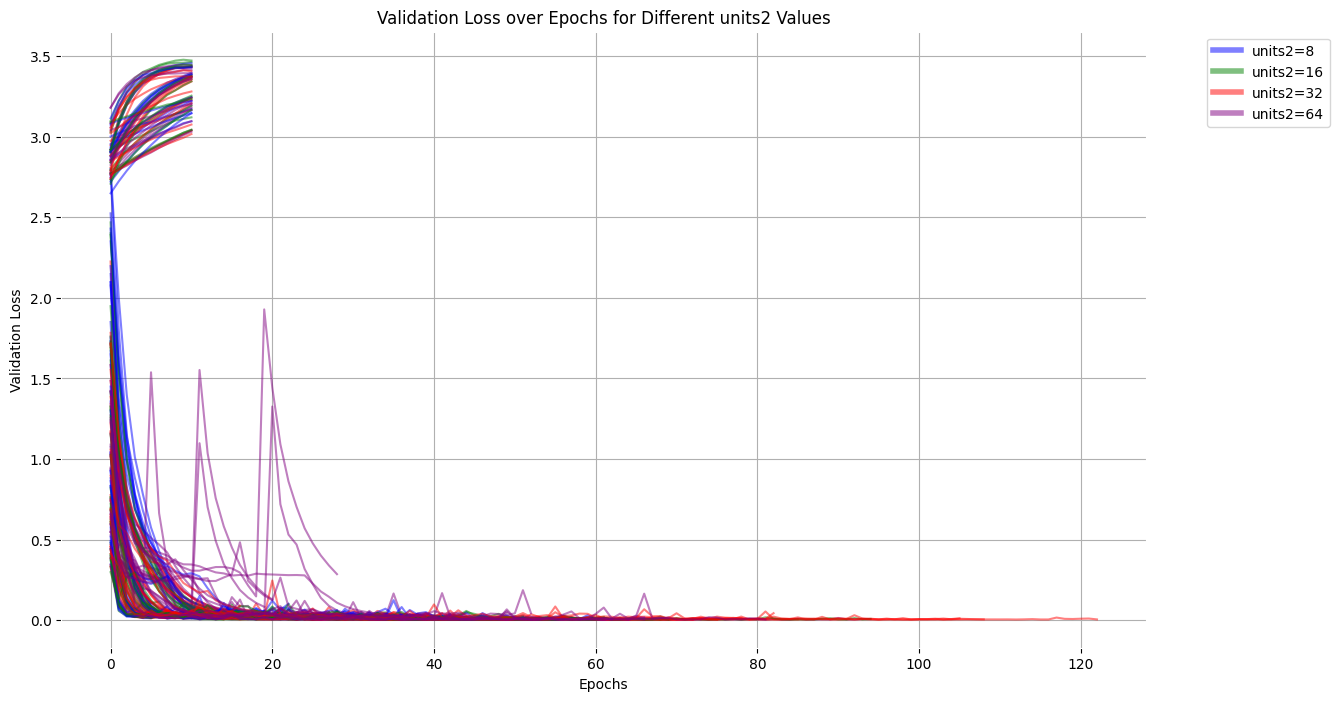

In [60]:
import matplotlib.pyplot as plt

# Define colors for different units2
units2_colors = {
    8: 'blue',
    16: 'green',
    32: 'red',
    64: 'purple'
}

# Collect unique units2 values
unique_units2 = set(result['units2'] for result in results)

plt.figure(figsize=(14, 8))

for result in results:
    label = f"units1={result['units1']}, units2={result['units2']}, batch_size={result['batch_size']}, optimizer={result['optimizer']}"
    color = units2_colors.get(result['units2'], 'black')  # default to black if units2 not in dict
    plt.plot(result['history'], label=label, color=color, alpha=0.5)

# Create custom legend for units2
handles = [plt.Line2D([0], [0], color=units2_colors[unit], lw=4, alpha=0.5) for unit in unique_units2]
labels = [f"units2={unit}" for unit in unique_units2]

plt.title('Validation Loss over Epochs for Different units2 Values')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


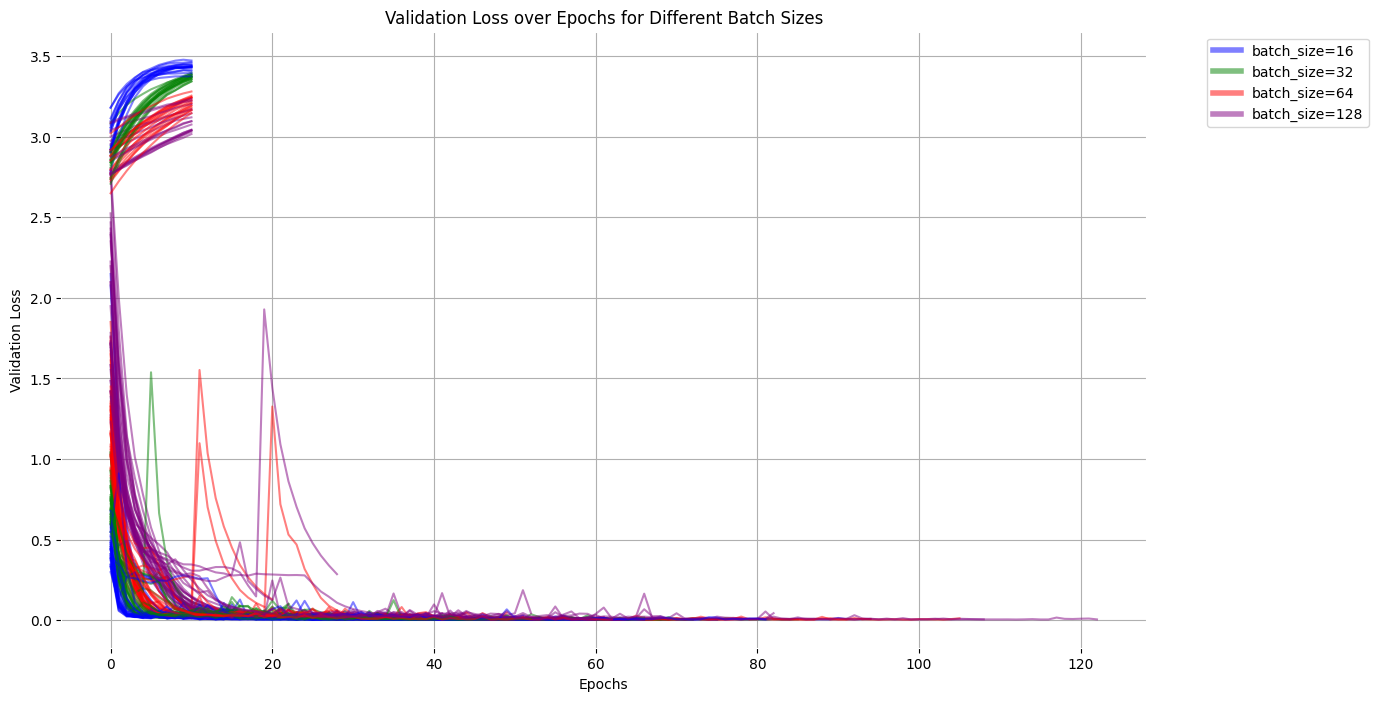

In [61]:
import matplotlib.pyplot as plt

# Define colors for different batch sizes
batch_size_colors = {
    16: 'blue',
    32: 'green',
    64: 'red',
    128: 'purple'
}

# Collect unique batch sizes
unique_batch_sizes = set(result['batch_size'] for result in results)

plt.figure(figsize=(14, 8))

for result in results:
    label = f"units1={result['units1']}, units2={result['units2']}, batch_size={result['batch_size']}, optimizer={result['optimizer']}"
    color = batch_size_colors.get(result['batch_size'], 'black')  # default to black if batch_size not in dict
    plt.plot(result['history'], label=label, color=color, alpha=0.5)

# Create custom legend for batch sizes
handles = [plt.Line2D([0], [0], color=batch_size_colors[batch], lw=4, alpha=0.5) for batch in unique_batch_sizes]
labels = [f"batch_size={batch}" for batch in unique_batch_sizes]

plt.title('Validation Loss over Epochs for Different Batch Sizes')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


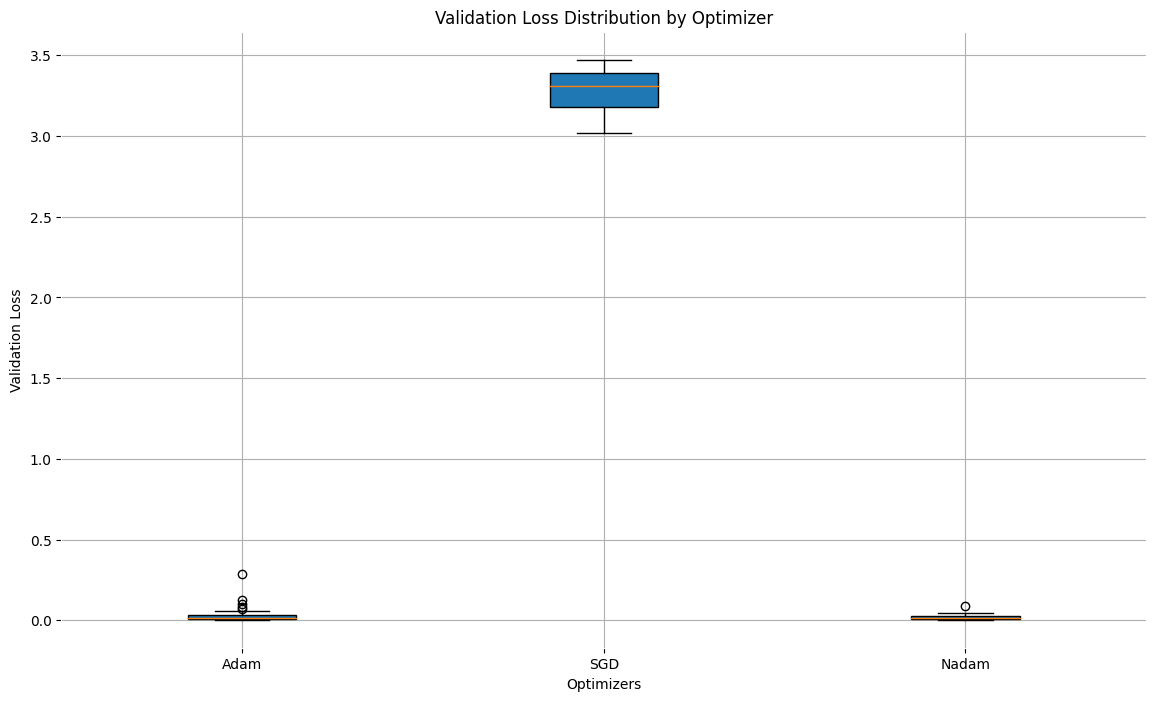

In [67]:
import matplotlib.pyplot as plt

# Prepare data for boxplot
optimizers = ['Adam', 'SGD', 'Nadam']
val_loss_histories_by_optimizer = {opt: [] for opt in optimizers}

for result in results:
    optimizer = result['optimizer']
    if optimizer in val_loss_histories_by_optimizer:
        # Append the final validation loss for each run to the list
        val_loss_histories_by_optimizer[optimizer].append(result['history'][-1])

# Create boxplot
fig, ax = plt.subplots(figsize=(14, 8))

# Extract data and labels
data = [val_loss_histories_by_optimizer[opt] for opt in optimizers]
labels = optimizers

# Create boxplot
ax.boxplot(data, vert=True, patch_artist=True, labels=labels)
plt.xticks(rotation=0)
plt.title('Validation Loss Distribution by Optimizer')
plt.xlabel('Optimizers')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()

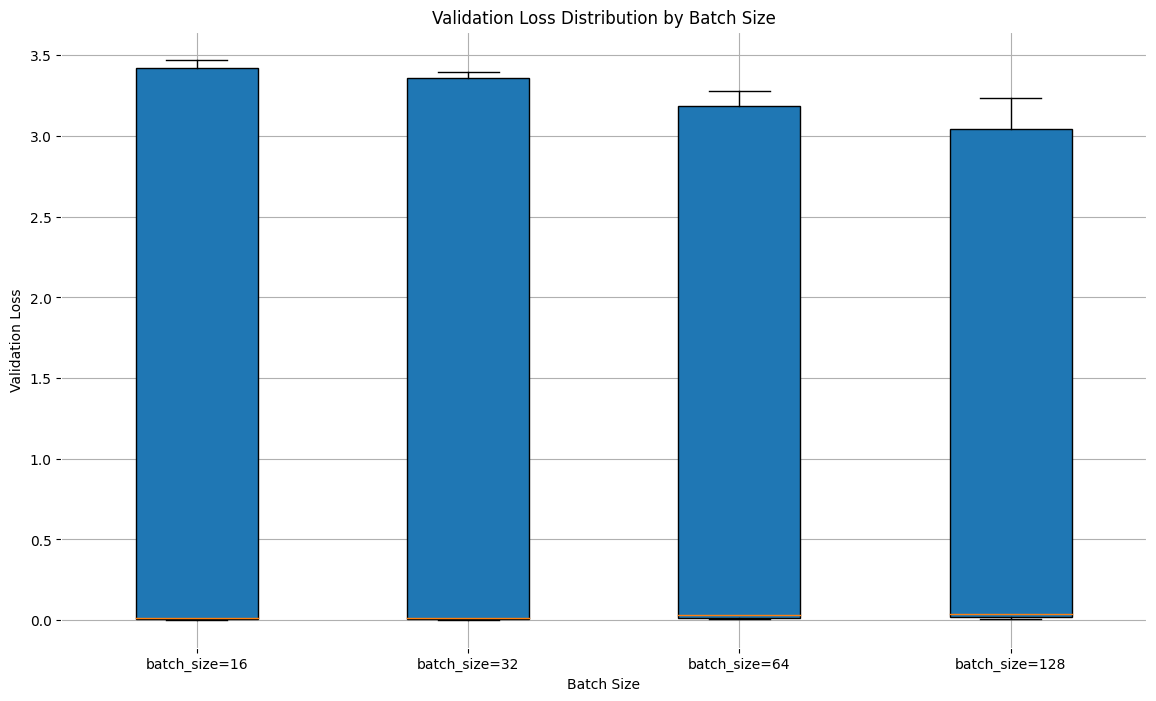

In [71]:
import matplotlib.pyplot as plt

# Prepare data for boxplot
batch_sizes = [16, 32, 64, 128]
final_val_loss_by_batch_size = {batch: [] for batch in batch_sizes}

for result in results:
    batch_size = result['batch_size']
    if batch_size in final_val_loss_by_batch_size:
        # Append only the final validation loss
        final_val_loss_by_batch_size[batch_size].append(result['history'][-1])

# Create boxplot
fig, ax = plt.subplots(figsize=(14, 8))

# Extract data and labels
data = [final_val_loss_by_batch_size[batch] for batch in batch_sizes]
labels = [f"batch_size={batch}" for batch in batch_sizes]

# Create boxplot
ax.boxplot(data, vert=True, patch_artist=True, labels=labels)
plt.xticks(rotation=0)
plt.title('Validation Loss Distribution by Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()

In [64]:
result = best_model.evaluate(X_test, y_test)
y_pred = best_model.predict(X_test)

12/12 [==============================] - 1s 6ms/step


In [65]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)


In [66]:
print("Test Loss:", result)
print("Test MAE:", MAE)
print("Test MAPE:", MAPE)
print("Test R2 Score:", R2)


Test Loss: 0.003979784902185202
Test MAE: 0.046357123970126236
Test MAPE: 0.02818279448347829
Test R2 Score: 0.9732510951642781


Epoch 1/300
24/24 [==============================] - 0s 19ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 2/300
24/24 [==============================] - 0s 20ms/step - loss: 0.0037 - val_loss: 0.0053
Epoch 3/300
24/24 [==============================] - 0s 18ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 4/300
24/24 [==============================] - 0s 19ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 5/300
24/24 [==============================] - 0s 20ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 6/300
24/24 [==============================] - 0s 17ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 7/300
24/24 [==============================] - 0s 20ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 8/300
24/24 [==============================] - 0s 17ms/step - loss: 0.0038 - val_loss: 0.0051
Epoch 9/300
24/24 [==============================] - 0s 20ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 10/300
24/24 [==============================] - 0s 16ms/step - loss: 0.0040 - val_loss: 0.0035

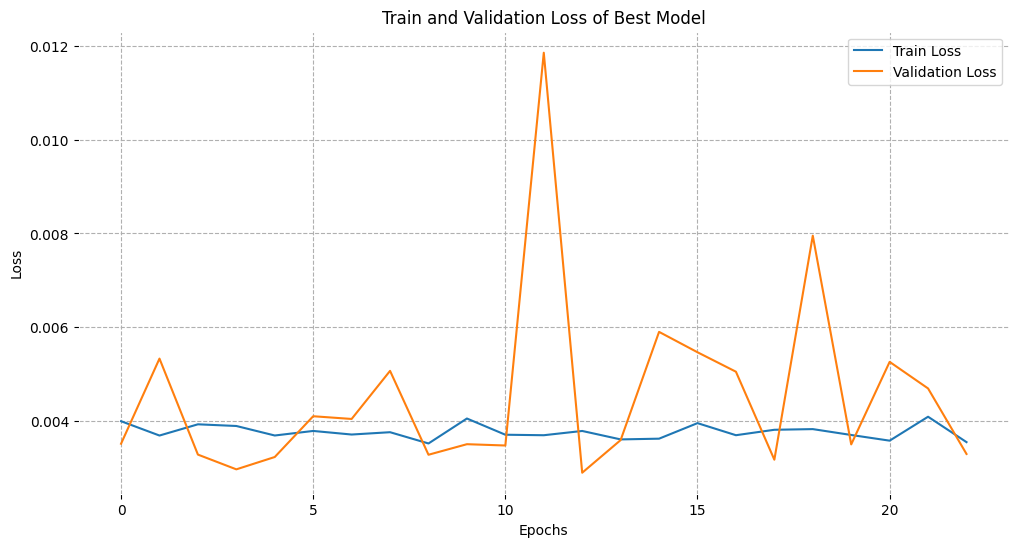

In [79]:
history = best_model.fit(X_train, y_train, epochs=300, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[early_stopping])

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss of Best Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(linestyle= "--")
plt.show()

# Step 12: Visualizing Results

In [84]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

result_linear = scaler.inverse_transform(result_linear.reshape(-1, 1))
result_rf = scaler.inverse_transform(result_rf.reshape(-1, 1))
result_svm = scaler.inverse_transform(result_svm.reshape(-1, 1))

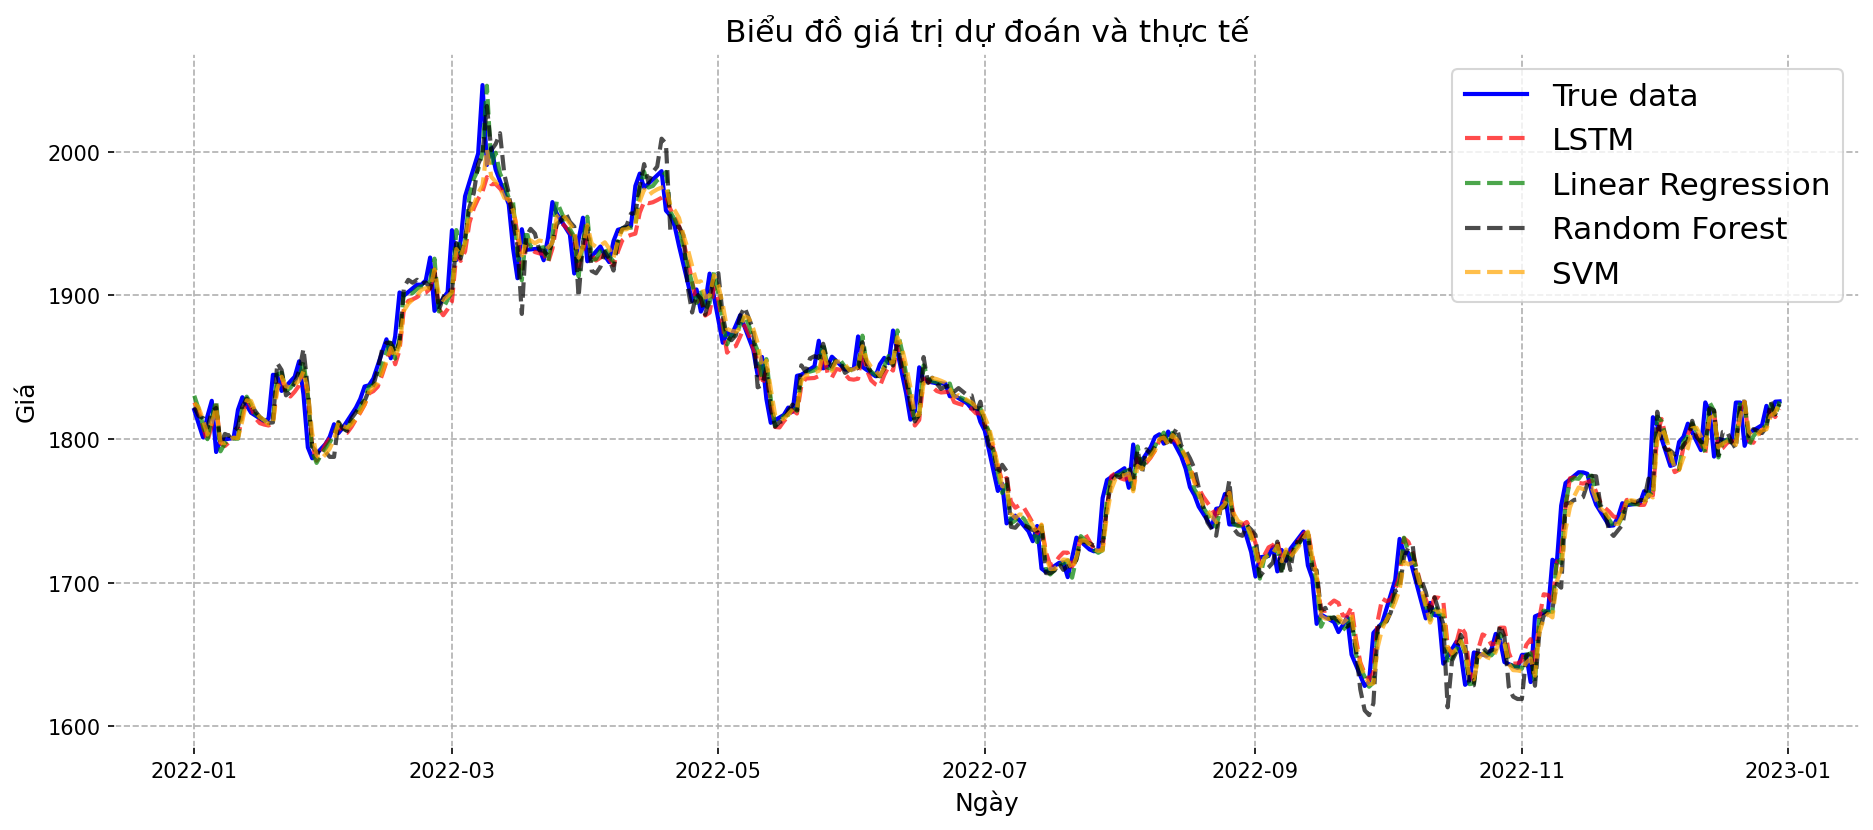

In [89]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rc('axes',edgecolor='white')
# plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2, label= "True data")

# Vẽ đường dự đoán LSTM
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', linestyle='--', lw=2, alpha=0.7, label="LSTM")

# Vẽ đường dự đoán hồi quy tuyến tính
plt.plot(df['Date'].iloc[-test_size:], result_linear, color='green', linestyle='--', lw=2, alpha=0.7, label='Linear Regression')

# Vẽ đường dự đoán Random Forest
plt.plot(df['Date'].iloc[-test_size:], result_rf, color='black', linestyle='--', lw=2, alpha=0.7, label='Random Forest')

# Vẽ đường dự đoán SVM
plt.plot(df['Date'].iloc[-test_size:], result_svm, color='orange', linestyle='--', lw=2, alpha=0.7, label='SVM')

plt.grid(linestyle= "--")
plt.title('Biểu đồ giá trị dự đoán và thực tế', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá', fontsize=12)
plt.legend( loc='upper right', prop={'size': 15})
plt.show()